In [1]:
import pandas as pd
import numpy as np
import sys

data = pd.read_csv('https://raw.githubusercontent.com/Ragnarok540/pdg/main/tags.txt', sep='~', header=None)

data.columns = ['links', 'req']

def add_categories(df):
  bins = [0, 11, 120, sys.maxsize]
  labels = ['low', 'moderate', 'high']
  category = pd.cut(df['links'], bins=bins, labels=labels)
  df['category'] = category
  return df

add_categories(data)

data["label"] = data["category"].cat.codes

data.head()

,links,req,category,label
0,198,The solution should provide detailed context s...,high,2
1,282,The solution should provide an interface for t...,high,2
2,34,"The solution should send alerts (for example, ...",moderate,1
3,8,The solution should enable the user to track t...,low,0
4,401597,The solution should enable the help desk user ...,high,2


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

ngram = True
tf_idf = True

if ngram:
  ngram_range = (1, 3)
else:
  ngram_range = (1, 1)

count_vect = CountVectorizer(ngram_range=ngram_range)
X_train_count = count_vect.fit_transform(data['req'])

if tf_idf:
  tfidf_transformer = TfidfTransformer()
  X_train_count = tfidf_transformer.fit_transform(X_train_count)

y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X_train_count, y, test_size=0.2, random_state=1) # 80% training and 20% test

X_train_count.shape

(5291, 110291)

In [3]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

In [4]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')

pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [5]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [50, 100, 150]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [None, 10, 50, 100]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
               
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto'],
 'min_samples_split': [2, 5],
 'n_estimators': [50, 100, 150]}


In [6]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

grid_search.best_params_

In [7]:
clf = RandomForestClassifier(bootstrap=False, max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=5, n_estimators=150)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [8]:
import seaborn as sns

def cf_matrix_plot(cf_matrix):
  group_names = ['True Low', 'False Moderate', 'False High', 'False Low', 'True Moderate', 'False High', 'False Low', 'False Moderate', 'True High']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(3,3)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


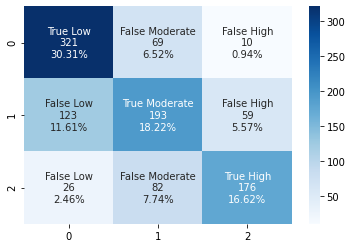

In [9]:
cf_matrix_plot(cf_matrix)

In [10]:
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       400
           1       0.56      0.51      0.54       375
           2       0.72      0.62      0.67       284

    accuracy                           0.65      1059
   macro avg       0.65      0.65      0.65      1059
weighted avg       0.65      0.65      0.65      1059

